# Proyecto Final - Análisis de Evasión de Clientes (Churn) en Telecom X

Este análisis forma parte del desafío final del módulo de análisis de datos. Tiene como objetivo identificar patrones y factores asociados a la evasión de clientes utilizando un enfoque ETL (Extract, Transform, Load) con Python y análisis exploratorio de datos (EDA).


## 1. Importación de librerías y carga de datos desde la API

En esta sección se importan las bibliotecas necesarias y se carga el dataset de Telecom X desde una API en formato JSON.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests


In [2]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"



In [3]:
df = pd.read_json(url)

In [4]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [5]:
# Ver las primeras filas
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2. Proceso ETL: Limpieza y Transformación de Datos

Aquí se realiza la expansión de columnas anidadas, detección y tratamiento de valores nulos, renombrado de columnas y creación de nuevas variables como `Cuentas_Diarias`. También se estandarizan los valores para facilitar el análisis posterior.


In [6]:
# Copia de seguridad
df_original = df.copy()


In [7]:
# Expandimos cada columna que contiene un dict
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

In [8]:
df_clean = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)


In [9]:
# Ver cantidad de nulos por columna
df_clean.isnull().sum()

,0
customerID,0
Churn,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


In [10]:
# Ver porcentaje de nulos por columna
(df_clean.isnull().mean() * 100).round(2)


,0
customerID,0.0
Churn,0.0
gender,0.0
SeniorCitizen,0.0
Partner,0.0
Dependents,0.0
tenure,0.0
PhoneService,0.0
MultipleLines,0.0
InternetService,0.0


In [11]:
# Verificar duplicados
df_clean.duplicated().sum()

np.int64(0)

In [12]:
# Si los valores nulos son pocos y no críticos, puedes eliminarlos
df_clean = df_clean.dropna()

In [13]:
print(df_clean.columns.tolist())


['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']


In [14]:
df_clean = df_clean.rename(columns={'Charges.Total': 'TotalCharges'})
df_clean = df_clean.rename(columns={'Charges.Monthly': 'MonthlyCharges'})


In [15]:
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'].isnull().sum()

np.int64(11)

In [16]:
# Rellenar los nulos con la mediana (u otra estrategia)
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median())


In [17]:
# Crear columna “Cuentas_Diarias”
df_clean['Cuentas_Diarias'] = df_clean['MonthlyCharges'] / 30


In [18]:
# Estandarización y transformación de datos
yes_no_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in yes_no_cols:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})


In [19]:
# Traduccion de columnas en ingles aun
df_clean = df_clean.rename(columns={
    'SeniorCitizen': 'AdultoMayor',
    'tenure': 'TiempoContratoMeses',
    'MonthlyCharges': 'CargoMensual',
    'TotalCharges': 'CargoTotal',
    'Contract': 'TipoContrato'
})


In [20]:
df_clean['gender'] = df_clean['gender'].map({
    'Female': 'Femenino',
    'Male': 'Masculino'
})

In [21]:
df_clean['TipoContrato'] = df_clean['TipoContrato'].map({
    'Month-to-month': 'Mensual',
    'One year': 'Un año',
    'Two year': 'Dos años'
})


In [22]:
df_clean.describe()


,Churn,AdultoMayor,Partner,Dependents,TiempoContratoMeses,PhoneService,PaperlessBilling,CargoMensual,CargoTotal,Cuentas_Diarias
count,7043.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.265370,0.162653,0.484106,0.300124,32.346498,0.902711,0.593230,64.720098,2279.287581,2.157337
std,0.441561,0.369074,0.499782,0.458343,24.571773,0.296371,0.491265,30.129572,2267.178963,1.004319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.425000,401.400000,1.180833
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,1391.000000,2.343333
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.875000,3778.525000,2.995833
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,3.958333


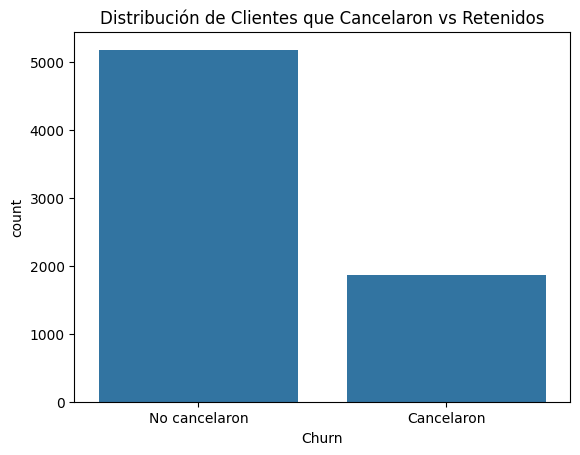

In [23]:
# Distribución de evasión (Churn)
sns.countplot(data=df_clean, x='Churn')
plt.title('Distribución de Clientes que Cancelaron vs Retenidos')
plt.xticks([0, 1], ['No cancelaron', 'Cancelaron'])
plt.show()


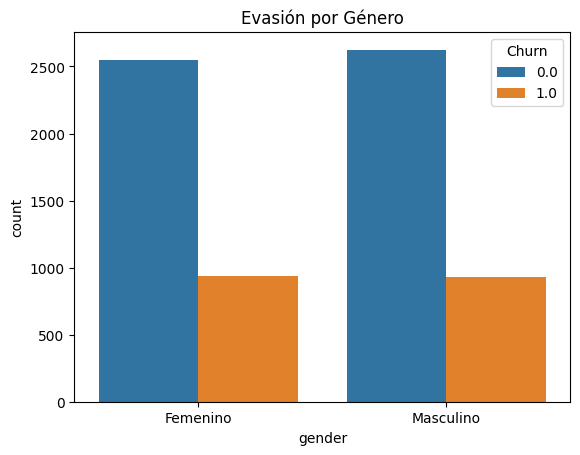

In [24]:
# Churn por variables categóricas
sns.countplot(data=df_clean, x='gender', hue='Churn')
plt.title('Evasión por Género')
plt.show()


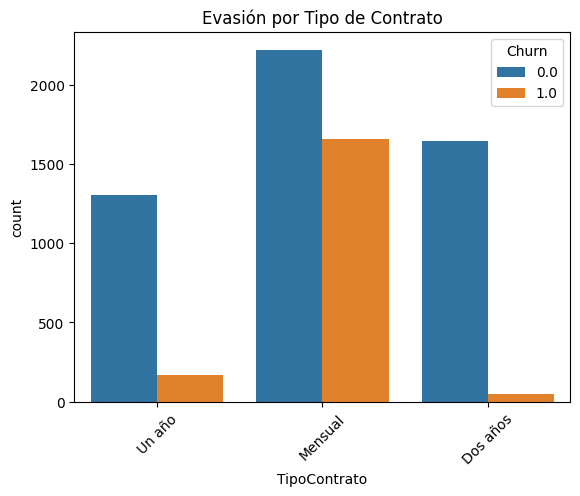

In [25]:
sns.countplot(data=df_clean, x='TipoContrato', hue='Churn')
plt.xticks(rotation=45)
plt.title('Evasión por Tipo de Contrato')
plt.show()


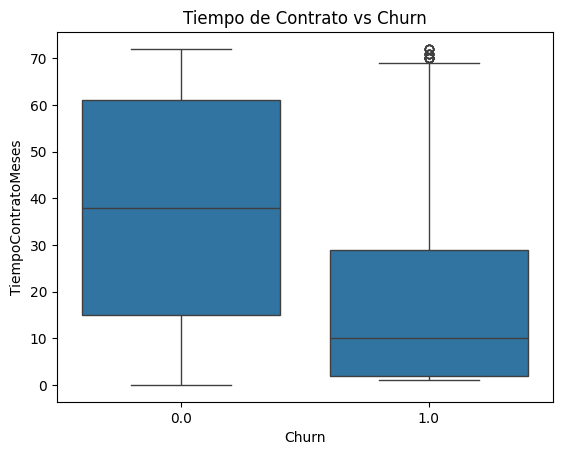

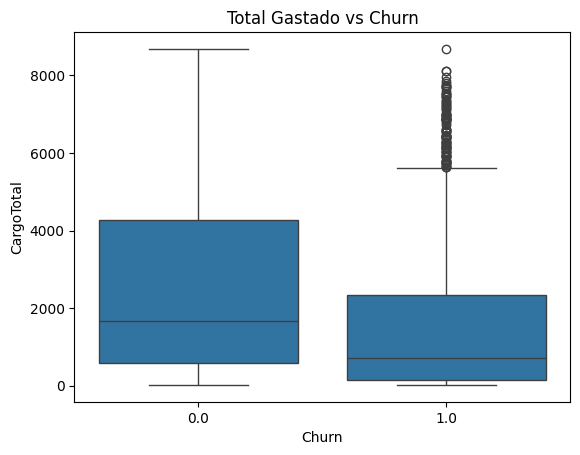

In [26]:
# Churn por variables numéricas
sns.boxplot(data=df_clean, x='Churn', y='TiempoContratoMeses')
plt.title('Tiempo de Contrato vs Churn')
plt.show()

sns.boxplot(data=df_clean, x='Churn', y='CargoTotal')
plt.title('Total Gastado vs Churn')
plt.show()


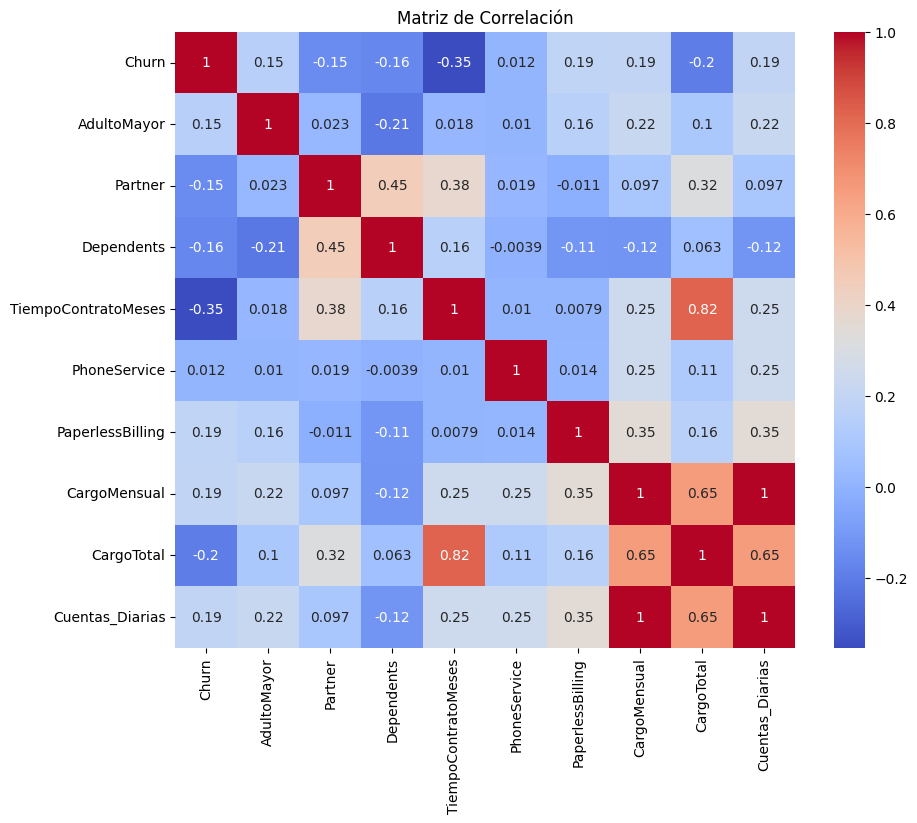

In [27]:
# Correlación entre variables (opcional)
correlacion = df_clean.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


## 3. Análisis Exploratorio de Datos (EDA)

Se analizan variables categóricas y numéricas para detectar patrones relacionados con la evasión de clientes. Se generan visualizaciones para facilitar la interpretación de resultados.


## 4. Informe Final y Conclusiones

### 🎯 Objetivo
Analizar los datos de clientes de Telecom X para comprender los factores que influyen en la evasión y apoyar la toma de decisiones estratégicas.

### 📌 Principales Hallazgos
- Los contratos mensuales tienen una tasa de cancelación mucho mayor.
- Clientes con bajo tiempo de permanencia tienden a abandonar más rápido.
- El método de pago también influye en la evasión.

### ✅ Recomendaciones
- Ofrecer beneficios en contratos de largo plazo.
- Descuentos a nuevos clientes durante sus primeros meses.
- Promover medios de pago automáticos como tarjetas o transferencias.

### 📈 Próximos pasos
Implementar modelos de predicción de churn y campañas personalizadas para reducir cancelaciones.
